This notebook demonstrates usage of domain decomposition in a simulation, including how to set up domain decomposition parameters and how to post-process domain-seperated tally data using the Python API.


In [1]:
%matplotlib inline
import glob
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd

import openmc

## Generate Input Files

Basically domain decomposition parameters are to be defined in the `settings.xml` file. We can just use the normal way to define materials, geometry, tallies and plots.

**Create materials**

Three materials for the fuel, water, and cladding of the fuel pin are created and written to materials XML file.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
b10 = openmc.Nuclide('B10')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
zr90 = openmc.Nuclide('Zr90')

# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

# Create materials file
# Instantiate a Materials collection
materials_file = openmc.Materials((fuel, water, zircaloy))
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

**Create geometry**

This problem will be a 17x17 rectangular lattice with a 1.26 cm pitch while each pitch contains three regions for the fuel, the clad, and the surrounding coolant.

In [3]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='vacuum')
min_y = openmc.YPlane(y0=-10.71, boundary_type='vacuum')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10.71, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10.71, boundary_type='reflective')

# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel - 0BA')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2
assembly.universes = [[pin_cell_universe] * 17] * 17

# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

# Export to "geometry.xml"
geometry.export_to_xml()

**Simulation parameters**

In this case, we will use 20 inactive batches and 80 active batches each with 2500 particles.

In [4]:
# OpenMC simulation parameters
batches = 100
inactive = 20
particles = 2500

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

Now we can **set domain decomposition parameters**. By defining a 2x2x1 cartesian mesh of 22cmx22cmx22cm in size to cover the whole geometry, we are going to simulate this model using 4 domains. Since the 4 domains are symmetric, a uniform nodemap is defined.

In [5]:
# Domain mesh
settings_file.dd_mesh_dimension = [2, 2, 1]
settings_file.dd_mesh_lower_left = [-11, -11, -11]
settings_file.dd_mesh_upper_right = [11,  11,  11]

# Nodemap to specify the distribution of load for all domains
settings_file.dd_nodemap = [1, 1, 1, 1]

Let's generate the "settings.xml" input file.

In [6]:
# Export to "settings.xml"
settings_file.export_to_xml()

**Plot geometry with domain meshlines**

Let us create a plot file to verify that our pin cell geometry was created successfully. The domain meshlines are to be plotted on top the geometry figure.

In [7]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.width = [22.5, 22.5]
plot.pixels = [250, 250]
plot.color = 'mat'

# Plot domain meshlines and set line color to be green
plot.meshlines = {
    'type': 'domain_decomposition',
    'linewidth': 1,
    'color': (0,255,0)
}

# Instantiate a Plots collection and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [8]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

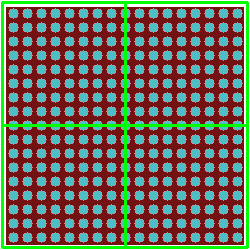

In [9]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have constructed a nice array of pin cells and the spatial geometry is divided into 4 domains in xy plane.

**Create tallies**

We will set up a fission rate mesh tally, a cell tally with nuclides and a "distribcell" Tally.

In [10]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()
tallies_file._tallies = []

# Instantiate a tally Mesh
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.width = [1.26, 1.26]

# Instantiate tally Filter
mesh_filter = openmc.Filter()
mesh_filter.mesh = mesh

# Instantiate energy Filter
energy_filter = openmc.Filter()
energy_filter.type = 'energy'
energy_filter.bins = np.array([0, 0.625e-6, 20.])

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter, energy_filter]
tally.scores = ['fission', 'nu-fission']

# Add mesh and Tally to Tallies
tallies_file.append(tally)

# Instantiate tally Filter
cell_filter = openmc.Filter(type='cell', bins=[fuel_cell.id])

# Instantiate the tally
tally = openmc.Tally(name='cell tally')
tally.filters = [cell_filter]
tally.scores = ['scatter-y2']
tally.nuclides = [u235, u238]

# Add mesh and tally to Tallies
tallies_file.append(tally)

# Instantiate tally Filter
distribcell_filter = openmc.Filter(type='distribcell', bins=[moderator_cell.id])

# Instantiate tally Trigger for kicks
trigger = openmc.Trigger(trigger_type='std_dev', threshold=5e-5)
trigger.scores = ['absorption']

# Instantiate the Tally
tally = openmc.Tally(name='distribcell tally')
tally.filters = [distribcell_filter]
tally.scores = ['absorption', 'scatter']
tally.triggers = [trigger]

# Add mesh and tally to Tallies
tallies_file.append(tally)

# Export to "tallies.xml"
tallies_file.export_to_xml()

## Run OpenMC

Now we a have a complete set of inputs, so we can go ahead and run our simulation. Note that domain decomposition must be run in a MPI parallel mode and the number of parallel processors **must be equal or greater** than the number of domains.

In [11]:
# Run OpenMC!
openmc.run(mpi_procs=4)


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

The domain decomposed simulation ran successfully. But it created 4 domain-specified statepoint files, in which tally data of different domains are saved. Each domain generates one statepoint file because it allocates tally arrays on-the-fly and stores only tally data of that domain. That's why domain decomposition can save memory when large-scale tallies are required. However, tally data processing is still simple using Python API even though the tally data are seperated. One can just load the 1st domain statepoint file (".domain_1.h5"). The Python API will link automatically all other domain-specified statepoints and merge the tally data together. All the features for tally processing can be used normally.

In [12]:
# Load 1st domain specified statepoint file
sp = openmc.StatePoint('statepoint.100.domain_1.h5')

**Analyze the mesh fission rate tally**

In [13]:
# Find the mesh tally with the StatePoint API
tally = sp.get_tally(name='mesh tally')

# Print a little info about the mesh tally to the screen
print(tally)

Tally
	ID             =	10000
	Name           =	mesh tally
	Filters        =	
                		mesh	[1]
                		energy	[  0.00000000e+00   6.25000000e-07   2.00000000e+01]
	Nuclides       =	total 
	Scores         =	[u'fission', u'nu-fission']
	Estimator      =	tracklength



Use the new Tally data retrieval API with pure NumPy

In [14]:
# Get the relative error for the thermal fission reaction 
# rates in the four corner pins 
data = tally.get_values(scores=['fission'], filters=['mesh', 'energy'], \
                        filter_bins=[((1,1),(1,17), (17,1), (17,17)), \
                                    ((0., 0.625e-6),)], value='rel_err')
print(data)

[[[ 0.07240824]]

 [[ 0.14730398]]

 [[ 0.03262544]]

 [[ 0.07514138]]]


In [15]:
# Get a pandas dataframe for the mesh tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Set the Pandas float display settings
pd.options.display.float_format = '{:.2e}'.format

# Print the first twenty rows in the dataframe
df.head(20)

mesh 1       energy low [MeV] energy high [MeV]       score     mean  \
        x  y  z                                                           
0       1  1  1         0.00e+00          6.25e-07     fission 2.10e-04   
1       1  1  1         0.00e+00          6.25e-07  nu-fission 5.13e-04   
2       1  1  1         6.25e-07          2.00e+01     fission 6.83e-05   
3       1  1  1         6.25e-07          2.00e+01  nu-fission 1.80e-04   
4       1  2  1         0.00e+00          6.25e-07     fission 2.51e-04   
5       1  2  1         0.00e+00          6.25e-07  nu-fission 6.11e-04   
6       1  2  1         6.25e-07          2.00e+01     fission 7.04e-05   
7       1  2  1         6.25e-07          2.00e+01  nu-fission 1.87e-04   
8       1  3  1         0.00e+00          6.25e-07     fission 2.03e-04   
9       1  3  1         0.00e+00          6.25e-07  nu-fission 4.95e-04   
10      1  3  1         6.25e-07          2.00e+01     fission 7.12e-05   
11      1  3  1         6.25e-07          2.00e+01  nu-fission 1.88e-04   
12      1  4  1         0.00e+00          6.25e-07     fission 1.80e-04   
13      1  4  1         0.00e+00          6.25e-07  nu-fission 4.40e-04   
14      1  4  1         6.25e-07          2.00e+01     fission 6.64e-05   
15      1  4  1         6.25e-07          2.00e+01  nu-fission 1.75e-04   
16      1  5  1         0.00e+00          6.25e-07     fission 1.76e-04   
17      1  5  1         0.00e+00          6.25e-07  nu-fission 4.29e-04   
18      1  5  1         6.25e-07          2.00e+01     fission 6.63e-05   
19      1  5  1         6.25e-07          2.00e+01  nu-fission 1.75e-04   

   std. dev.  
              
0   1.52e-05  
1   3.71e-05  
2   2.70e-06  
3   6.97e-06  
4   1.58e-05  
5   3.84e-05  
6   2.39e-06  
7   6.37e-06  
8   1.32e-05  
9   3.21e-05  
10  2.80e-06  
11  7.16e-06  
12  1.41e-05  
13  3.45e-05  
14  2.19e-06  
15  5.72e-06  
16  1.36e-05  
17  3.30e-05  
18  2.52e-06  
19  6.60e-06

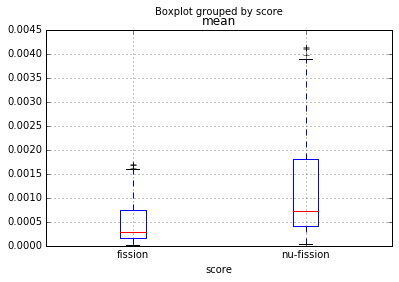

In [16]:
# Create a boxplot to view the distribution of
# fission and nu-fission rates in the pins
bp = df.boxplot(column='mean', by='score')

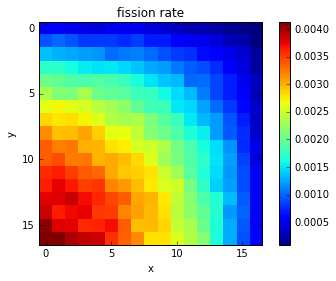

In [17]:
# Extract thermal nu-fission rates from pandas
fiss = df[df['score'] == 'nu-fission']
fiss = fiss[fiss['energy low [MeV]'] == 0.0]

# Extract mean and reshape as 2D NumPy arrays
mean = fiss['mean'].reshape((17,17))

plt.imshow(mean, interpolation='nearest')
plt.title('fission rate')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

**Analyze the cell+nuclides scatter-y2 rate tally**

In [18]:
# Find the cell Tally with the StatePoint API
tally = sp.get_tally(name='cell tally')

# Print a little info about the cell tally to the screen
print(tally)

Tally
	ID             =	10001
	Name           =	cell tally
	Filters        =	
                		cell	[10000]
	Nuclides       =	U235 U238 
	Scores         =	[u'scatter-Y0,0', u'scatter-Y1,-1', u'scatter-Y1,0', u'scatter-Y1,1', u'scatter-Y2,-2', u'scatter-Y2,-1', u'scatter-Y2,0', u'scatter-Y2,1', u'scatter-Y2,2']
	Estimator      =	analog



In [19]:
# Get a pandas dataframe for the cell tally data
df = tally.get_pandas_dataframe()

# Print the first twenty rows in the dataframe
df.head(100)

,cell,nuclide,score,mean,std. dev.
0,10000,U235,"scatter-Y0,0",3.87e-02,8.49e-04
1,10000,U235,"scatter-Y1,-1",7.74e-04,3.16e-04
2,10000,U235,"scatter-Y1,0",2.64e-04,3.12e-04
3,10000,U235,"scatter-Y1,1",-4.85e-04,3.11e-04
4,10000,U235,"scatter-Y2,-2",-1.24e-04,1.73e-04
5,10000,U235,"scatter-Y2,-1",1.18e-04,1.87e-04
6,10000,U235,"scatter-Y2,0",1.73e-05,1.94e-04
7,10000,U235,"scatter-Y2,1",-8.55e-05,1.86e-04
8,10000,U235,"scatter-Y2,2",-7.16e-05,2.02e-04
9,10000,U238,"scatter-Y0,0",2.34e+00,1.26e-02


Use the new Tally data retrieval API with pure NumPy

In [20]:
# Get the standard deviations for two of the spherical harmonic
# scattering reaction rates 
data = tally.get_values(scores=['scatter-Y2,2', 'scatter-Y0,0'], 
                        nuclides=['U238', 'U235'], value='std_dev')
print(data)

[[[ 0.00146466  0.01257252]
  [ 0.00020214  0.00084864]]]


**Analyze the distribcell tally**

In [21]:
# Find the distribcell Tally with the StatePoint API
tally = sp.get_tally(name='distribcell tally')

# Print a little info about the distribcell tally to the screen
print(tally)

Tally
	ID             =	10002
	Name           =	distribcell tally
	Filters        =	
                		distribcell	[10002]
	Nuclides       =	total 
	Scores         =	[u'absorption', u'scatter']
	Estimator      =	tracklength



Use the new Tally data retrieval API with pure NumPy

In [22]:
# Get the relative error for the scattering reaction rates in
# the first 10 distribcell instances 
data = tally.get_values(scores=['scatter'], filters=['distribcell'],
                        filter_bins=[(i,) for i in range(10)], value='rel_err')
print(data)

[[[ 0.01821191]]]


Print the distribcell tally dataframe

In [23]:
# Get a pandas dataframe for the distribcell tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Print the last twenty rows in the dataframe
df.tail(20)

level 1        level 2            level 3        distribcell       score  \
       univ   cell     lat               univ   cell                           
         id     id      id   x   y  z      id     id                           
558       0  10003   10001  16   7  0   10000  10002         279  absorption   
559       0  10003   10001  16   7  0   10000  10002         279     scatter   
560       0  10003   10001  16   8  0   10000  10002         280  absorption   
561       0  10003   10001  16   8  0   10000  10002         280     scatter   
562       0  10003   10001  16   9  0   10000  10002         281  absorption   
563       0  10003   10001  16   9  0   10000  10002         281     scatter   
564       0  10003   10001  16  10  0   10000  10002         282  absorption   
565       0  10003   10001  16  10  0   10000  10002         282     scatter   
566       0  10003   10001  16  11  0   10000  10002         283  absorption   
567       0  10003   10001  16  11  0   10000  10002         283     scatter   
568       0  10003   10001  16  12  0   10000  10002         284  absorption   
569       0  10003   10001  16  12  0   10000  10002         284     scatter   
570       0  10003   10001  16  13  0   10000  10002         285  absorption   
571       0  10003   10001  16  13  0   10000  10002         285     scatter   
572       0  10003   10001  16  14  0   10000  10002         286  absorption   
573       0  10003   10001  16  14  0   10000  10002         286     scatter   
574       0  10003   10001  16  15  0   10000  10002         287  absorption   
575       0  10003   10001  16  15  0   10000  10002         287     scatter   
576       0  10003   10001  16  16  0   10000  10002         288  absorption   
577       0  10003   10001  16  16  0   10000  10002         288     scatter   

        mean std. dev.  
                        
                        
558 8.34e-05  4.20e-06  
559 1.30e-02  3.04e-04  
560 8.88e-05  5.55e-06  
561 1.39e-02  3.50e-04  
562 9.82e-05  4.65e-06  
563 1.50e-02  2.58e-04  
564 1.04e-04  4.47e-06  
565 1.57e-02  2.56e-04  
566 1.19e-04  5.68e-06  
567 1.67e-02  3.27e-04  
568 1.13e-04  4.41e-06  
569 1.68e-02  3.09e-04  
570 1.11e-04  4.55e-06  
571 1.75e-02  3.00e-04  
572 1.23e-04  5.05e-06  
573 1.83e-02  3.51e-04  
574 1.26e-04  5.78e-06  
575 1.80e-02  3.70e-04  
576 1.18e-04  6.28e-06  
577 1.79e-02  3.95e-04

In [24]:
# Show summary statistics for absorption distribcell tally data
absorption = df[df['score'] == 'absorption']
absorption[['mean', 'std. dev.']].dropna().describe()

# Note that the maximum standard deviation does indeed
# meet the 5e-4 threshold set by the tally trigger

,mean,std. dev.
,,
,,
count,2.89e+02,2.89e+02
mean,4.19e-04,1.10e-05
std,2.41e-04,4.24e-06
min,1.85e-05,2.04e-06
25%,2.07e-04,7.78e-06
50%,3.93e-04,1.12e-05
75%,6.25e-04,1.39e-05
max,9.07e-04,2.48e-05
